# Question

How much reputation does the average Stack Overflow **User** have when awarded its first [tag-badge](https://stackoverflow.com/help/badges#:~:text=3.1m%20awarded-,Tag%20Badges,-Bronze%20Badge)?

## Some considerations:

- The first tag badge will always be [bronze](https://stackoverflow.com/help/badges?tab=tags&filter=bronze)
    - > Earn at least 100 total score for at least 20 non-community wiki answers in the python tag.
    - My first tag badge was `python`
- The StackAPI [throttles](https://api.stackexchange.com/docs/throttle) the number of daily calls
- The API does ***not*** return the date that a user was awarded a tag badge (that I know of). I will need to make calls to different endpoints and construct a historical log of events to determine when the badge was awarded.

## [End-points](https://api.stackexchange.com/docs) to explore:

|Category|Sub Category|Endpoint|Description|
|-|-|-|-|
|Per-Site Methods|Answers|[`"answers/{ids}"`](https://api.stackexchange.com/docs/answers-by-ids)|Get answers identified by a set of ids.|
|Per-Site Methods|Answers|[`"answers/{ids}/questions"`](https://api.stackexchange.com/docs/questions-by-answer-ids)|Gets all questions the answers identified by ids are on.|
|Per-Site Methods|Badges|[`"badges/{ids}/recipients"`](https://api.stackexchange.com/docs/badge-recipients-by-ids)|Get the recent recipients of the given badges.|
|Per-Site Methods|Posts|[`"posts/{ids}"`](https://api.stackexchange.com/docs/posts-by-ids)|Get all posts identified by a set of ids. Useful for when the type of post (question or answer) is not known.|
|Per-Site Methods|Questions|[`"questions/{ids}"`](https://api.stackexchange.com/docs/questions-by-ids)|Get the questions identified by a set of ids.|
|Per-Site Methods|Users|[`"users/{ids}/answers"`](https://api.stackexchange.com/docs/answers-on-users)|Get the answers posted by the users identified by a set of ids.|
|Per-Site Methods|Users|[`"users/{ids}/badges"`](https://api.stackexchange.com/docs/badges-on-users)|Get the badges the users in {ids} have earned.|
|Per-Site Methods|Users|[`"users/{ids}/posts"`](https://api.stackexchange.com/docs/posts-on-users)|Get all posts (questions and answers) owned by a set of users.|
|Per-Site Methods|Users|[`"users/{ids}/questions"`](https://api.stackexchange.com/docs/questions-on-users)|Get the questions asked by the users identified by a set of ids.|
|Per-Site Methods|Users|[`"users/{ids}/reputation"`](https://api.stackexchange.com/docs/reputation-on-users)|Get a subset of the reputation changes experienced by the users identified by a set of ids.|
|Per-Site Methods|Users|[`"users/{ids}/reputation-history"`](https://api.stackexchange.com/docs/reputation-history)|Get a history of a user's reputation, excluding private events.|
|~~Per-Site Methods~~|~~Users~~|~~[`"users/{id}/reputation-history/full"`](https://api.stackexchange.com/docs/full-reputation-history)~~|~~Get a full history of a user's reputation. `[auth required]`~~|
|Per-Site Methods|Users|[`"users/{ids}/timeline"`](https://api.stackexchange.com/docs/timeline-on-users)|Get a subset of the actions of that have been taken by the users identified by a set of ids.|
|~~Network Methods~~|~~Achievements~~|~~[`"users/{id}/achievements"`](https://api.stackexchange.com/docs/achievements-on-user)~~|~~Get a user's recent network-wide achievements. `[auth required]`~~|

After some exploration, I have not figured out how to generate an `access_token`.

# Setup

In [1]:
cd ..

C:\Users\A2644752\Sandbox\GitHub\AnalysisOverflow


In [2]:
# 3rd party
from matplotlib import pyplot as plt
import pandas as pd

# application specific
from analysis_overflow.stackoverflow import StackOverflow

In [3]:
my_user_id = 6509519

bronze_python_badge_id = 267

In [5]:
# connect to API
so = StackOverflow(user_id=my_user_id, max_pages=100)

# Analysis

### User = me 🙂

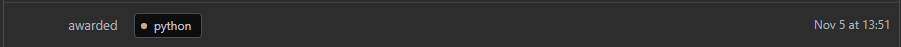

##### Answers

In [13]:
my_answers = so.fetch_user_answers()

In [14]:
my_answers = pd.DataFrame(my_answers.get("items"))

question_ids = my_answers.question_id.unique()

##### Questions

In [15]:
# TODO -- can this be threaded?
question_items = []
for i in range(0, len(question_ids), 100):
    # api limits to 100 ids
    question_items.extend(so.fetch_questions(question_ids=question_ids[i:i+100]).get("items"))

In [16]:
questions = pd.DataFrame(question_items)

questions = questions.set_index("question_id", verify_integrity=True)

questions = questions.explode(column="tags")

##### Python Questions

In [17]:
python_questions = questions.loc[
    questions.tags.eq("python")
].copy()

##### Python Answers

In [18]:
my_python_answers = my_answers.loc[
    my_answers.question_id.isin(python_questions.index)
].copy()

##### Reputation

In [19]:
my_reputation_hist = so.fetch_user_reputation_history()

In [20]:
rep_hist = pd.DataFrame(my_reputation_hist.get("items"))

rep_hist["creation_date"] = pd.to_datetime(rep_hist.creation_date, unit="s")

rep_hist = rep_hist.sort_values("creation_date")

##### Python Answer Reputation

In [21]:
python_answer_rep = rep_hist.loc[
    rep_hist.post_id.isin(my_python_answers.answer_id)
    & rep_hist.reputation_history_type.isin([
        "answer_accepted",
        "answer_unaccepted",
    ]).eq(False)
].copy()

##### Tag Badge Awarded

In [22]:
award_time = python_answer_rep.loc[
    lambda row: row["reputation_change"].cumsum().eq(1000),
    "creation_date"
].iloc[0]

##### Total Reputation at Time of Award

In [23]:
award_rep = rep_hist.loc[
    rep_hist.creation_date.le(award_time),
    "reputation_change"
].sum()

##### Reputation Over Time

In [24]:
rep_over_time = rep_hist[["creation_date", "reputation_change"]].copy()

rep_over_time["cumulative_reputation"] = rep_over_time.reputation_change.cumsum()

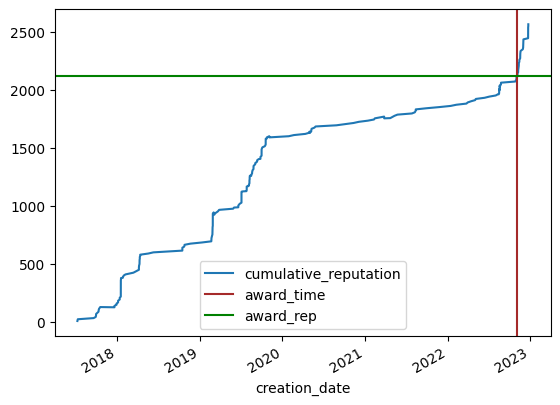

In [25]:
fig, ax = plt.subplots()
rep_over_time.plot("creation_date", "cumulative_reputation", ax=ax)
ax.axvline(award_time, color="brown", label="award_time")
ax.axhline(award_rep, color="green", label="award_rep")
ax.legend()
plt.show()

### Others

##### Tag Badges

In [7]:
results = so.fetch("badges", sort="type", min="tag_based")

In [8]:
items = results.get("items")

tag_badges = pd.DataFrame(items)

##### Bronze Tag Badges

In [10]:
bronze_tag_badges = tag_badges.loc[tag_badges["rank"].eq("bronze")].copy()

bronze_tag_badge_ids = bronze_tag_badges.badge_id.to_numpy()

##### Bronze Tag Badge Recipients

In [12]:
bronze_tag_badge_recipients = []
for i in range(0, len(bronze_tag_badge_ids), 100):
    results = so.fetch_badge_recipients(badge_ids=bronze_tag_badge_ids[i:i+100])
    items = results.get("items")
    bronze_tag_badge_recipients.extend(items)

In [13]:
bronze_tag_badge_recipients = pd.DataFrame(bronze_tag_badge_recipients)

bronze_tag_badge_recipients_ids = pd.DataFrame(bronze_tag_badge_recipients["user"].to_list())["user_id"]

bronze_tag_badge_recipients_ids = bronze_tag_badge_recipients_ids.unique()

In [16]:
len(bronze_tag_badge_recipients_ids)

56340

##### User Badges

In [136]:
# user_badges = []
# for i in range(0, len(bronze_tag_badge_recipients_ids), 100):
#     res = so.fetch("users/{ids}/badges", ids=bronze_tag_badge_recipients_ids[i:i+100], sort="type", min="tag_based")
#     items = res.get("items")
#     user_badges.extend(items)

In [139]:
user_badges = pd.DataFrame(user_badges)

user_badge_user_ids = pd.DataFrame(user_badges["user"].to_list())["user_id"]

user_badge_user_ids = user_badge_user_ids.unique()

##### User Bronze Badges

How to determine a user's *first* badge?

In [217]:
user_bronze_badges = user_badges.loc[user_badges["rank"].eq("bronze")].copy()

In [219]:
pd.DataFrame(user_bronze_badges["user"].to_list())

,reputation,user_id,user_type,profile_image,display_name,link,accept_rate
0,77640,214790,registered,https://www.gravatar.com/avatar/f878c823034273...,matt,https://stackoverflow.com/users/214790/matt,NaN
1,113571,1899640,registered,https://www.gravatar.com/avatar/47374ccb28e4b0...,that other guy,https://stackoverflow.com/users/1899640/that-o...,NaN
2,30271,1026,registered,https://www.gravatar.com/avatar/ea331e778d54ef...,Nickolay,https://stackoverflow.com/users/1026/nickolay,60.0
3,327491,18771,registered,https://www.gravatar.com/avatar/0ada184c98bf90...,Tomalak,https://stackoverflow.com/users/18771/tomalak,87.0
4,194809,248823,registered,https://www.gravatar.com/avatar/6605deca5924e8...,Marcin,https://stackoverflow.com/users/248823/marcin,100.0
...,...,...,...,...,...,...,...
172867,3892,4718283,registered,https://i.stack.imgur.com/aQJJn.jpg?s=256&g=1,Husayn Hakeem,https://stackoverflow.com/users/4718283/husayn...,74.0
172868,3190,2418642,registered,https://www.gravatar.com/avatar/661bf0e57b634f...,sgjesse,https://stackoverflow.com/users/2418642/sgjesse,NaN
172869,3172,1452382,registered,https://www.gravatar.com/avatar/8c3938cece44ef...,dlam,https://stackoverflow.com/users/1452382/dlam,NaN
172870,2972,704837,registered,https://www.gravatar.com/avatar/2446a7dad1b7cb...,koush,https://stackoverflow.com/users/704837/koush,NaN


##### Users

In [ ]:
# user_items = []
# for i in range(0, len(user_badge_user_ids), 100):
#     res = so.fetch("users/{ids}", ids=user_badge_user_ids[i:i+100])
#     items = res.get("items")
#     user_items.extend(items)

In [197]:
users = pd.DataFrame(user_items)

users = users.set_index("user_id")

In [209]:
users["badge_counts"].apply(pd.Series)

KeyboardInterrupt: 

In [211]:
user_badges = pd.DataFrame(users["badge_counts"].to_list(), index=users.index)

,bronze,silver,gold
user_id,,,
3732271,622,504,35
13302,1440,1320,172
1126841,645,497,69
2225682,618,697,61
18771,619,519,66
...,...,...,...
1452382,18,15,0
1686989,24,18,0
704837,31,26,0


In [77]:
# 4th quarter 2022 badge recipients
from_date = pd.to_datetime("20221001")
to_date = pd.to_datetime("20221231")

results = so.fetch(endpoint="badges/recipients", fromdate=from_date, todate=to_date)

In [78]:
items = results.get("items")

In [80]:
recipients = pd.DataFrame(items)

In [84]:
recipients.badge_type.value_counts()

named        9972
tag_based      28
Name: badge_type, dtype: int64

In [83]:
recipients.loc[recipients.badge_type]

,user,badge_type,rank,badge_id,link,name
0,"{'reputation': 1, 'user_id': 20897121, 'user_t...",named,bronze,9,https://stackoverflow.com/badges/9/autobiographer,Autobiographer
1,"{'reputation': 1, 'user_id': 20897280, 'user_t...",named,bronze,9,https://stackoverflow.com/badges/9/autobiographer,Autobiographer
2,"{'reputation': 1, 'user_id': 20897035, 'user_t...",named,bronze,9,https://stackoverflow.com/badges/9/autobiographer,Autobiographer
3,"{'reputation': 1, 'user_id': 20897179, 'user_t...",named,bronze,9,https://stackoverflow.com/badges/9/autobiographer,Autobiographer
4,"{'reputation': 1, 'user_id': 20856214, 'user_t...",named,bronze,9,https://stackoverflow.com/badges/9/autobiographer,Autobiographer
...,...,...,...,...,...,...
9995,"{'reputation': 1, 'user_id': 20890224, 'user_t...",named,bronze,2600,https://stackoverflow.com/badges/2600/informed,Informed
9996,"{'reputation': 1, 'user_id': 19558830, 'user_t...",named,bronze,2600,https://stackoverflow.com/badges/2600/informed,Informed
9997,"{'reputation': 1, 'user_id': 20889447, 'user_t...",named,bronze,9,https://stackoverflow.com/badges/9/autobiographer,Autobiographer
9998,"{'reputation': 588, 'user_id': 2537027, 'user_...",named,bronze,1973,https://stackoverflow.com/badges/1973/caucus,Caucus


In [199]:
recipients = so.fetch(f"badges/{bronze_python_badge_id}/recipients")

recipients_df = pd.DataFrame(recipients.get("items"))

recipients_users_df = pd.DataFrame(recipients_df["user"].to_list())

user_ids = recipients_users_df["user_id"].unique()

Get user posts tagged with `python`

In [211]:
my_posts = so.fetch("users/{ids}/posts", ids=[me])

my_posts_df = pd.DataFrame(my_posts.get("items"))

my_answer_posts = my_posts_df.loc[my_posts_df.post_type.eq("answer")].copy()

my_answer_post_ids = my_answer_posts.post_id.unique()

In [239]:
questions_answered = so.fetch("answers/{ids}/questions", ids=my_answer_post_ids[:100])

questions_answered_df = pd.DataFrame(questions_answered.get("items"))

questions_tagged_with_python = questions_answered_df.loc[
    questions_answered_df["tags"].apply(lambda x: "python" in x).eq(True)
].copy()

python_question_ids = questions_tagged_with_python.question_id.unique()

In [270]:
questions_tagged_with_python

,tags,owner,is_answered,view_count,answer_count,score,last_activity_date,creation_date,last_edit_date,question_id,content_license,link,title,accepted_answer_id,closed_date,closed_reason
0,"[python, pandas, dataframe, replace, merge]","{'reputation': 1, 'user_id': 20889016, 'user_t...",True,36,2,0,1672344723,1672338802,1.672345e+09,74954851,CC BY-SA 4.0,https://stackoverflow.com/questions/74954851/i...,I want the rows in 2nd dataframe to replace co...,NaN,NaN,NaN
1,"[python, pandas, dataframe, web-scraping, data...","{'reputation': 19, 'user_id': 13829846, 'user_...",True,44,2,0,1672331276,1671738504,1.672331e+09,74893218,CC BY-SA 4.0,https://stackoverflow.com/questions/74893218/h...,How to scrape a table from a page and create a...,74893831.0,NaN,NaN
2,"[python, pandas, dataframe, numpy, glob]","{'reputation': 921, 'user_id': 2077648, 'user_...",True,54,1,-1,1672242022,1671723201,1.671726e+09,74890684,CC BY-SA 4.0,https://stackoverflow.com/questions/74890684/h...,How to generate a report in python containing ...,74891230.0,NaN,NaN
3,"[python, pandas, dataframe]","{'reputation': 29, 'user_id': 16704021, 'user_...",False,27,1,0,1671832005,1671829200,1.671832e+09,74903951,CC BY-SA 4.0,https://stackoverflow.com/questions/74903951/l...,Looping through Df and Merge result into a par...,NaN,NaN,NaN
4,"[python, pandas, dataframe, datetime, rolling-...","{'reputation': 147, 'user_id': 14281607, 'user...",True,28,1,0,1671738423,1671731101,NaN,74892096,CC BY-SA 4.0,https://stackoverflow.com/questions/74892096/r...,Rolling mean before specific datetime,74893211.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"[python, pandas, dataframe, initialization, ap...","{'reputation': 23, 'user_id': 11087858, 'user_...",True,1480,2,2,1550643218,1550635476,NaN,54778657,CC BY-SA 4.0,https://stackoverflow.com/questions/54778657/c...,Creating Empty Data Frame and adding Rows to it,54779235.0,NaN,NaN
95,"[python, pandas]","{'reputation': 13, 'user_id': 10488004, 'user_...",True,77,1,1,1540329589,1539381339,1.539382e+09,52787453,CC BY-SA 4.0,https://stackoverflow.com/questions/52787453/f...,Filtering for values in Pivot table columns,52819617.0,NaN,NaN
96,"[python, pandas]","{'reputation': 1739, 'user_id': 7877094, 'user...",True,1142,1,1,1539564317,1539511338,1.539520e+09,52801540,CC BY-SA 4.0,https://stackoverflow.com/questions/52801540/p...,Pandas groupby then rolling mean,52808384.0,NaN,NaN
98,"[python, pandas, pivot-table]","{'reputation': 31, 'user_id': 9556045, 'user_t...",False,78,1,1,1523976304,1523717302,1.523946e+09,49832708,CC BY-SA 3.0,https://stackoverflow.com/questions/49832708/p...,plot legend in multi_index figure plot,NaN,NaN,NaN


In [265]:
python_question_answers = so.fetch("questions/{ids}/answers", ids=python_question_ids[:100])

In [268]:
python_qa_df = pd.DataFrame(python_question_answers.get("items"))

In [275]:
python_qa_df.loc[
    python_qa_df.owner.apply(lambda row: row.get("user_id") == me).eq(True)
]

,owner,is_accepted,score,last_activity_date,creation_date,answer_id,question_id,content_license,last_edit_date
0,"{'reputation': 2539, 'user_id': 6509519, 'user...",False,0,1672341411,1672341411,74955231,74954851,CC BY-SA 4.0,NaN
2,"{'reputation': 2539, 'user_id': 6509519, 'user...",True,1,1672242022,1671726155,74891230,74890684,CC BY-SA 4.0,1.672242e+09
3,"{'reputation': 2539, 'user_id': 6509519, 'user...",False,0,1671831426,1671829718,74904008,74903951,CC BY-SA 4.0,1.671831e+09
5,"{'reputation': 2539, 'user_id': 6509519, 'user...",True,2,1671743126,1671743126,74893831,74893218,CC BY-SA 4.0,NaN
6,"{'reputation': 2539, 'user_id': 6509519, 'user...",True,0,1671738423,1671738423,74893211,74892096,CC BY-SA 4.0,NaN
...,...,...,...,...,...,...,...,...,...
130,"{'reputation': 2539, 'user_id': 6509519, 'user...",True,3,1550639433,1550639433,54779235,54778657,CC BY-SA 4.0,NaN
134,"{'reputation': 2539, 'user_id': 6509519, 'user...",True,0,1540329589,1539615757,52819617,52787453,CC BY-SA 4.0,1.540330e+09
135,"{'reputation': 2539, 'user_id': 6509519, 'user...",True,2,1539564317,1539564317,52808384,52801540,CC BY-SA 4.0,NaN
138,"{'reputation': 2539, 'user_id': 6509519, 'user...",False,0,1523976304,1523976304,49881148,49832708,CC BY-SA 3.0,NaN


### Users

In [7]:
# users = so.fetch("users")

In [20]:
users.keys()

dict_keys(['backoff', 'has_more', 'page', 'quota_max', 'quota_remaining', 'total', 'items'])

In [26]:
users.get("quota_remaining")

293

In [51]:
users_df = pd.DataFrame(users.get("items"))

In [52]:
users_df.head(2)

,badge_counts,account_id,is_employee,last_modified_date,last_access_date,reputation_change_year,reputation_change_quarter,reputation_change_month,reputation_change_week,reputation_change_day,reputation,creation_date,user_type,user_id,accept_rate,location,website_url,link,profile_image,display_name
0,"{'bronze': 9125, 'silver': 9025, 'gold': 846}",11683,False,1672231500,1672334662,71334,17764,5339,943,200,1376648,1222430705,registered,22656,86.0,"Reading, United Kingdom",http://csharpindepth.com,https://stackoverflow.com/users/22656/jon-skeet,https://www.gravatar.com/avatar/6d8ebb117e8d83...,Jon Skeet
1,"{'bronze': 759, 'silver': 612, 'gold': 53}",1165580,False,1671807902,1671812780,39419,9254,2666,400,60,1221206,1326311637,registered,1144035,NaN,"New York, United States",http://www.data-miners.com,https://stackoverflow.com/users/1144035/gordon...,https://www.gravatar.com/avatar/e514b017977ebf...,Gordon Linoff


### Badges

In [14]:
# badges = so.fetch("badges")

In [21]:
badges.get("quota_remaining")

292

In [29]:
badges_df = pd.DataFrame(badges.get("items"))

In [33]:
badges_df.head()

,badge_type,award_count,rank,badge_id,link,name
0,tag_based,1,bronze,8009,https://stackoverflow.com/badges/8009/networkd3,networkd3
1,tag_based,39,bronze,885,https://stackoverflow.com/badges/885/networking,networking
2,tag_based,16,bronze,2377,https://stackoverflow.com/badges/2377/network-...,network-programming
3,tag_based,1,bronze,11117,https://stackoverflow.com/badges/11117/network...,networkstream
4,tag_based,12,bronze,2798,https://stackoverflow.com/badges/2798/networkx,networkx


In [32]:
badges_df.badge_type.value_counts()

tag_based    100
Name: badge_type, dtype: int64

### Tag Badges

In [57]:
# tag_badges = so.fetch("badges", badge_type="tag_based")
# tag_badges = so.fetch("badges/tags")

In [58]:
tag_badges.get("quota_remaining")

284

In [62]:
tag_badges_df = pd.DataFrame(tag_badges.get("items"))

In [64]:
print(tag_badges_df.link.sample().to_numpy()[0])

https://stackoverflow.com/badges/10836/nearest-neighbor


In [73]:
tag_badges_df.head()

,badge_type,award_count,rank,badge_id,link,name
0,tag_based,1,bronze,6440,https://stackoverflow.com/badges/6440/n-gram,n-gram
1,tag_based,1,bronze,6140,https://stackoverflow.com/badges/6140/ng-repeat,ng-repeat
2,tag_based,1,bronze,9296,https://stackoverflow.com/badges/9296/ngroute,ngroute
3,tag_based,6,bronze,6944,https://stackoverflow.com/badges/6944/ngrx,ngrx
4,tag_based,1,bronze,9542,https://stackoverflow.com/badges/9542/ngrx-eff...,ngrx-effects


### Me

In [67]:
# me = so.fetch("users/{ids}", ids=[me_id])

In [68]:
me

{'backoff': 0,
 'has_more': False,
 'page': 1,
 'quota_max': 300,
 'quota_remaining': 283,
 'total': 0,
 'items': [{'badge_counts': {'bronze': 29, 'silver': 16, 'gold': 1},
   'account_id': 8698988,
   'is_employee': False,
   'last_modified_date': 1669311300,
   'last_access_date': 1672347529,
   'reputation_change_year': 713,
   'reputation_change_quarter': 503,
   'reputation_change_month': 483,
   'reputation_change_week': 0,
   'reputation_change_day': 0,
   'reputation': 2539,
   'creation_date': 1466780003,
   'user_type': 'registered',
   'user_id': 6509519,
   'location': 'Kansas City, MO, United States',
   'website_url': '',
   'link': 'https://stackoverflow.com/users/6509519/ian-thompson',
   'profile_image': 'https://i.stack.imgur.com/xEcoP.jpg?s=256&g=1',
   'display_name': 'Ian Thompson'}]}

In [69]:
me.get("quota_remaining")

283

In [70]:
me_df = pd.DataFrame(me.get("items"))

In [72]:
me_df

,badge_counts,account_id,is_employee,last_modified_date,last_access_date,reputation_change_year,reputation_change_quarter,reputation_change_month,reputation_change_week,reputation_change_day,reputation,creation_date,user_type,user_id,location,website_url,link,profile_image,display_name
0,"{'bronze': 29, 'silver': 16, 'gold': 1}",8698988,False,1669311300,1672347529,713,503,483,0,0,2539,1466780003,registered,6509519,"Kansas City, MO, United States",,https://stackoverflow.com/users/6509519/ian-th...,https://i.stack.imgur.com/xEcoP.jpg?s=256&g=1,Ian Thompson


### Bronze Python Recipients

In [74]:
# bronze_python = so.fetch("badges/{ids}/recipients", ids=[267])

In [75]:
bronze_python.get("quota_remaining")

255

In [76]:
bronze_python_df = pd.DataFrame(bronze_python.get("items"))

In [80]:
bronze_python_df["user"].apply(pd.Series)["reputation"].describe()

count       100.000000
mean       5960.830000
std       12855.868588
min        1236.000000
25%        2074.750000
50%        2948.500000
75%        4329.750000
max      115625.000000
Name: reputation, dtype: float64

<AxesSubplot: ylabel='Frequency'>

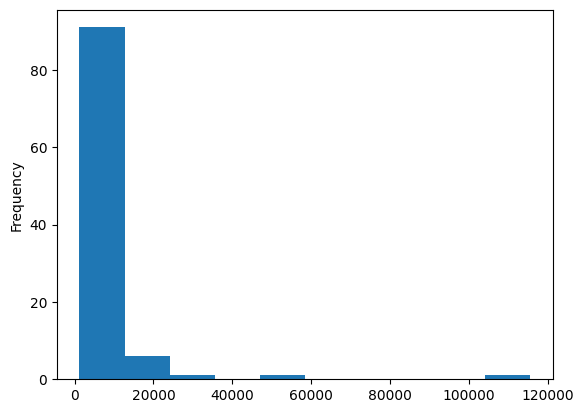

In [85]:
bronze_python_df["user"].apply(pd.Series)["reputation"].plot.hist()

### My Tag Badges

In [102]:
me_badges = so.fetch("users/{ids}/badges", ids=[me_id], min="tag_based", sort="type")

In [104]:
me_badges.get("quota_remaining")

240

In [105]:
me_badges_df = pd.DataFrame(me_badges.get("items"))

In [106]:
me_badges_df

,user,badge_type,award_count,rank,badge_id,link,name
0,"{'reputation': 2539, 'user_id': 6509519, 'user...",tag_based,1,bronze,267,https://stackoverflow.com/badges/267/python,python
1,"{'reputation': 2539, 'user_id': 6509519, 'user...",tag_based,1,bronze,1914,https://stackoverflow.com/badges/1914/pandas,pandas


In [119]:
pd.DataFrame(me_badges_df["user"].to_list())

,reputation,user_id,user_type,profile_image,display_name,link
0,2539,6509519,registered,https://i.stack.imgur.com/xEcoP.jpg?s=256&g=1,Ian Thompson,https://stackoverflow.com/users/6509519/ian-th...
1,2539,6509519,registered,https://i.stack.imgur.com/xEcoP.jpg?s=256&g=1,Ian Thompson,https://stackoverflow.com/users/6509519/ian-th...


### My Reputation

In [120]:
me_rep = so.fetch("users/{ids}/reputation", ids=[me_id])

In [122]:
me_rep.get("quota_remaining")

239

In [123]:
me_rep_df = pd.DataFrame(me_rep.get("items"))

In [127]:
me_rep_df.head()

,on_date,reputation_change,vote_type,post_type,post_id,user_id
0,1671805221,15,accepts,answer,74891230,6509519
1,1671805075,10,up_votes,answer,74891230,6509519
2,1671752093,15,accepts,answer,74893211,6509519
3,1671748623,50,up_votes,answer,44976660,6509519
4,1671748587,60,up_votes,question,58457181,6509519


In [126]:
me_rep_df.reputation_change.sum()

1513

## 2. Rookies<a id='2'></a>

In [213]:
# extract user information 
SITE = StackAPI('stackoverflow')
# SITE.page_size = 5 # limits to 5 returned results for demo purpose
SITE.max_pages = 5

# the date is specified to locate rookies that are more likely to have only one badge.
users = SITE.fetch('users',fromdate=datetime(2022,1,1), todate=datetime(2022,6,30))

In [317]:
answers = SITE.fetch('answers')
answers_info = pd.DataFrame(answers['items'])
answers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   owner                 2500 non-null   object 
 1   is_accepted           2500 non-null   bool   
 2   score                 2500 non-null   int64  
 3   last_activity_date    2500 non-null   int64  
 4   creation_date         2500 non-null   int64  
 5   answer_id             2500 non-null   int64  
 6   question_id           2500 non-null   int64  
 7   content_license       2500 non-null   object 
 8   last_edit_date        716 non-null    float64
 9   community_owned_date  5 non-null      float64
dtypes: bool(1), float64(2), int64(5), object(2)
memory usage: 178.3+ KB


In [236]:
user_info = pd.DataFrame(users['items'])
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   badge_counts               2500 non-null   object 
 1   account_id                 2500 non-null   int64  
 2   is_employee                2500 non-null   bool   
 3   last_modified_date         2229 non-null   float64
 4   last_access_date           2500 non-null   int64  
 5   reputation_change_year     2500 non-null   int64  
 6   reputation_change_quarter  2500 non-null   int64  
 7   reputation_change_month    2500 non-null   int64  
 8   reputation_change_week     2500 non-null   int64  
 9   reputation_change_day      2500 non-null   int64  
 10  reputation                 2500 non-null   int64  
 11  creation_date              2500 non-null   int64  
 12  user_type                  2500 non-null   object 
 13  user_id                    2500 non-null   int64

In [237]:
# Extract helpful information
user_info = user_info.drop(columns=['is_employee', 'last_modified_date', 'last_access_date', 'user_type', 'user_id', 'website_url', 'link', 'profile_image', 'display_name'])

In [238]:
# review badge info
user_info['badge_counts'][0]

{'bronze': 36, 'silver': 10, 'gold': 5}

In [239]:
# separate badge info
badge = user_info['badge_counts']
badge_count = pd.DataFrame(columns=['bronze', 'silver', 'gold'])
for i in range(len(badge)):
    badge_count=pd.concat([badge_count, pd.DataFrame(pd.Series(badge[i])).T], axis=0)
badge_count = badge_count.reset_index().drop(columns='index')
badge_count.head()

,bronze,silver,gold
0,36,10,5
1,41,13,2
2,28,11,5
3,42,21,3
4,29,6,2


In [240]:
badge_count['bronze'] = pd.to_numeric(badge_count['bronze'])
badge_count['silver'] = pd.to_numeric(badge_count['silver'])
badge_count['gold'] = pd.to_numeric(badge_count['gold'])

In [241]:
# Calculate total badges of users
user_info = pd.concat([user_info, badge_count], axis=1).drop(columns='badge_counts')
user_info['badge_total'] = user_info['bronze'] + user_info['silver'] + user_info['gold']

In [242]:
user_info.head()

,account_id,reputation_change_year,reputation_change_quarter,reputation_change_month,reputation_change_week,reputation_change_day,reputation,creation_date,location,bronze,silver,gold,badge_total
0,23959668,21335,5396,370,95,95,21336,1642371776,NaN,36,10,5,51
1,24301499,16672,6681,3275,0,0,16773,1645196209,"Dallas, Texas",41,13,2,56
2,23821874,10863,2676,60,0,0,10964,1641281645,California,28,11,5,44
3,23863113,10493,2321,1321,65,65,10494,1641580294,NaN,42,21,3,66
4,24576560,9295,2425,1290,10,10,9296,1647429576,NaN,29,6,2,37


In [243]:
# Calculate tenure based on creation date of users
user_info['creation_date'] = [datetime.fromtimestamp(user_info['creation_date'][i]).strftime('%Y-%m-%d') for i in range(user_info.shape[0])]
user_info['creation_date'] = pd.to_datetime(user_info['creation_date'])
user_info['tenure_day'] = (user_info['creation_date'].max() - user_info['creation_date']).dt.days

In [276]:
user_info.head()

,account_id,reputation_change_year,reputation_change_quarter,reputation_change_month,reputation_change_week,reputation_change_day,reputation,creation_date,location,bronze,silver,gold,badge_total,tenure_day
0,23959668,21335,5396,370,95,95,21336,2022-01-16,NaN,36,10,5,51,164
1,24301499,16672,6681,3275,0,0,16773,2022-02-18,"Dallas, Texas",41,13,2,56,131
2,23821874,10863,2676,60,0,0,10964,2022-01-04,California,28,11,5,44,176
3,23863113,10493,2321,1321,65,65,10494,2022-01-07,NaN,42,21,3,66,173
4,24576560,9295,2425,1290,10,10,9296,2022-03-16,NaN,29,6,2,37,105


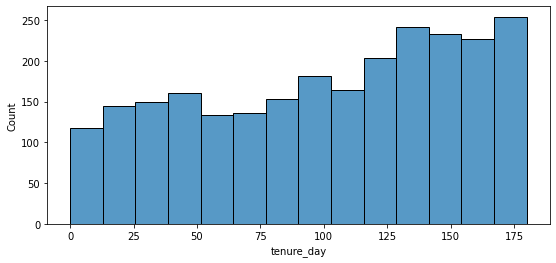

In [245]:
# the tenure of users collected in the dataset
plt.figure(figsize=(9,4))
sns.histplot(x='tenure_day', data=user_info)
plt.xlabel('tenure_day')
plt.show();

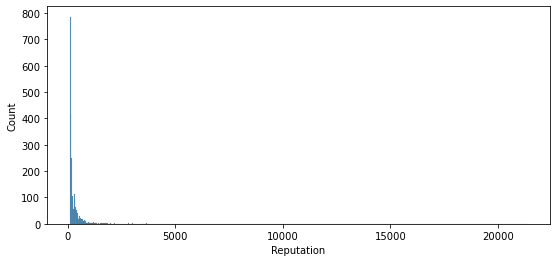

In [246]:
plt.figure(figsize=(9,4))
sns.histplot(x='reputation', data=user_info)
plt.xlabel('Reputation')
plt.show();

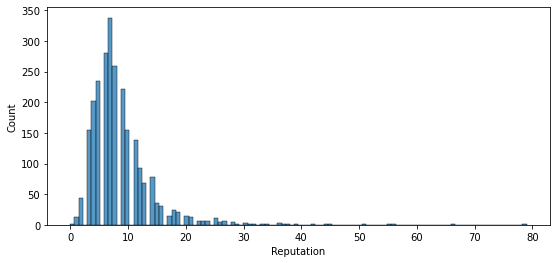

In [247]:
plt.figure(figsize=(9,4))
sns.histplot(x='badge_total', data=user_info)
plt.xlabel('Reputation')
plt.show();

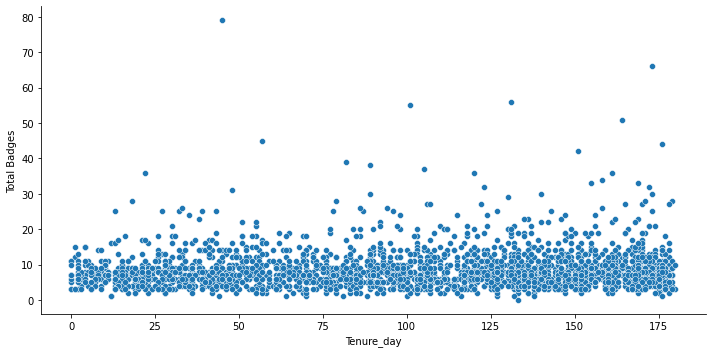

In [249]:
# total badges vs. tenure_year
sns.relplot(x='tenure_day', y='badge_total',data=user_info, kind='scatter',height=5,
    aspect=2)
plt.xlabel('Tenure_day')
plt.ylabel('Total Badges')
plt.show();

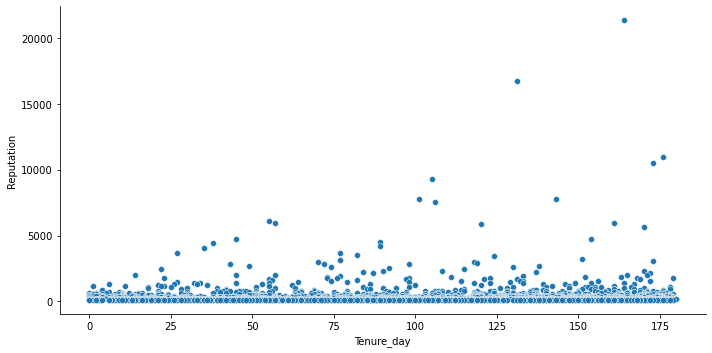

In [251]:
# reputation vs. tenure_year
sns.relplot(x='tenure_day', y='reputation',data=user_info, kind='scatter',height=5,
    aspect=2)
plt.xlabel('Tenure_day')
plt.ylabel('Reputation')
plt.show();

- there is no clear correlation between reputation and tenure.
- there is no clear correlation between total badges and tenure.

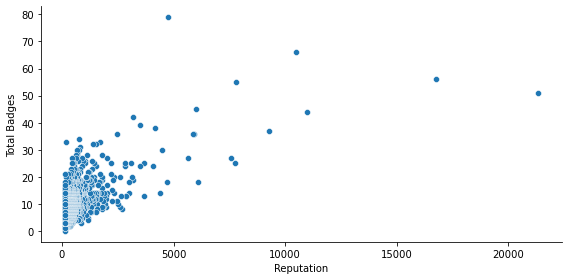

In [252]:
# total badges vs. reputation
sns.relplot(x='reputation', y='badge_total',data=user_info, kind='scatter',height=4,
    aspect=2)
plt.xlabel('Reputation')
plt.ylabel('Total Badges')
plt.show();

- A correlation exist between the total badges and reputation.

In [253]:
user_info.badge_total.describe()

count    2500.000000
mean        8.616000
std         5.505549
min         0.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        79.000000
Name: badge_total, dtype: float64

In [ ]:
one_badge = pd.DataFrame(user_info[user_info['bronze'] == 1]['reputation'].describe())

In [272]:
one_badge = pd.concat([one_badge, pd.DataFrame(user_info[user_info['silver'] == 1]['reputation'].describe())], axis=1)

In [273]:
one_badge = pd.concat([one_badge, pd.DataFrame(user_info[user_info['gold'] == 1]['reputation'].describe())], axis=1)

In [274]:
one_badge = pd.concat([one_badge, pd.DataFrame(user_info[user_info['badge_total'] == 1]['reputation'].describe())], axis=1)

In [277]:
one_badge.columns = ['bronze', 'silver', 'gold', 'any']
one_badge

,bronze,silver,gold,any
count,13.000000,680.000000,206.000000,13.000000
mean,140.461538,305.089706,813.218447,140.461538
std,18.791023,294.553419,848.149731,18.791023
min,121.000000,117.000000,121.000000,121.000000
25%,126.000000,146.000000,241.750000,126.000000
50%,131.000000,199.000000,486.500000,131.000000
75%,151.000000,346.000000,1131.000000,151.000000
max,181.000000,2886.000000,5626.000000,181.000000


- The user's first bronze badge requires 131.0 (median) reputation
- The user's first silver badge requires 199.0 (median) reputation
- The user's first gold badge requires 486.5 (median) reputation

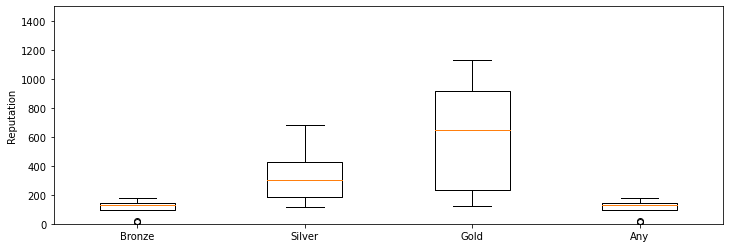

In [295]:
plt.figure(figsize=(12,4))
plt.boxplot(one_badge)
plt.xticks([1,2,3,4], labels=['Bronze', 'Silver', 'Gold', 'Any'])
plt.ylabel('Reputation')
plt.ylim(0, 1500)
plt.show();

## 3. Veterans<a id='3'></a>

In [296]:
# extract user information 
SITE = StackAPI('stackoverflow')
# SITE.page_size = 5 # limits to 5 returned results for demo purpose
SITE.max_pages = 25

# the date is not specified
users_veteran = SITE.fetch('users')

In [297]:
user_info = pd.DataFrame(users_veteran['items'])
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   badge_counts               2500 non-null   object 
 1   account_id                 2500 non-null   int64  
 2   is_employee                2500 non-null   bool   
 3   last_modified_date         2500 non-null   int64  
 4   last_access_date           2500 non-null   int64  
 5   reputation_change_year     2500 non-null   int64  
 6   reputation_change_quarter  2500 non-null   int64  
 7   reputation_change_month    2500 non-null   int64  
 8   reputation_change_week     2500 non-null   int64  
 9   reputation_change_day      2500 non-null   int64  
 10  reputation                 2500 non-null   int64  
 11  creation_date              2500 non-null   int64  
 12  user_type                  2500 non-null   object 
 13  user_id                    2500 non-null   int64

In [298]:
# Extract helpful information
user_info = user_info.drop(columns=['is_employee', 'last_modified_date', 'last_access_date', 'user_type', 'user_id', 'website_url', 'link', 'profile_image', 'display_name'])

In [299]:
# separate badge info
badge = user_info['badge_counts']
badge_count = pd.DataFrame(columns=['bronze', 'silver', 'gold'])
for i in range(len(badge)):
    badge_count=pd.concat([badge_count, pd.DataFrame(pd.Series(badge[i])).T], axis=0)
badge_count = badge_count.reset_index().drop(columns='index')
badge_count.head()

,bronze,silver,gold
0,9115,9012,844
1,757,610,53
2,4952,4198,502
3,3529,3579,366
4,2917,3262,267


In [300]:
badge_count['bronze'] = pd.to_numeric(badge_count['bronze'])
badge_count['silver'] = pd.to_numeric(badge_count['silver'])
badge_count['gold'] = pd.to_numeric(badge_count['gold'])

In [301]:
# Calculate total badges of users
user_info = pd.concat([user_info, badge_count], axis=1).drop(columns='badge_counts')
user_info['badge_total'] = user_info['bronze'] + user_info['silver'] + user_info['gold']

In [302]:
# Calculate tenure based on creation date of users
user_info['creation_date'] = [datetime.fromtimestamp(user_info['creation_date'][i]).strftime('%Y-%m-%d') for i in range(user_info.shape[0])]
user_info['creation_date'] = pd.to_datetime(user_info['creation_date'])
user_info['tenure_day'] = (user_info['creation_date'].max() - user_info['creation_date']).dt.days

In [303]:
user_info.head()

,account_id,reputation_change_year,reputation_change_quarter,reputation_change_month,reputation_change_week,reputation_change_day,reputation,creation_date,accept_rate,location,bronze,silver,gold,badge_total,tenure_day
0,11683,66691,13121,705,130,130,1371975,2008-09-26,86.0,"Reading, United Kingdom",9115,9012,844,18971,4659
1,1165580,37101,6936,3653,50,50,1218868,2012-01-11,NaN,"New York, United States",757,610,53,1420,3457
2,4243,78729,14742,920,215,215,1173022,2008-09-13,100.0,France,4952,4198,502,9652,4672
3,52822,38416,6325,271,40,40,1060587,2009-08-17,93.0,"Willemstad, Cura&#231;ao",3529,3579,366,7474,4334
4,14332,25354,4291,240,70,70,1008158,2008-10-19,86.0,"Sofia, Bulgaria",2917,3262,267,6446,4636


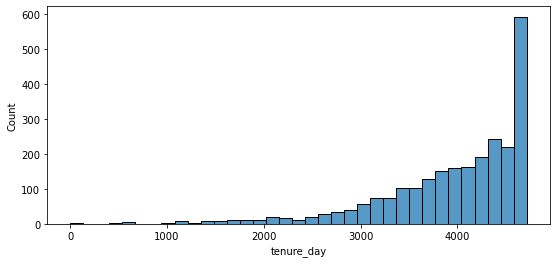

In [304]:
# the tenure of users collected in the dataset
plt.figure(figsize=(9,4))
sns.histplot(x='tenure_day', data=user_info)
plt.xlabel('tenure_day')
plt.show();

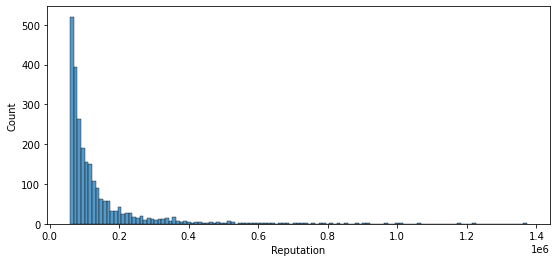

In [305]:
plt.figure(figsize=(9,4))
sns.histplot(x='reputation', data=user_info)
plt.xlabel('Reputation')
plt.show();

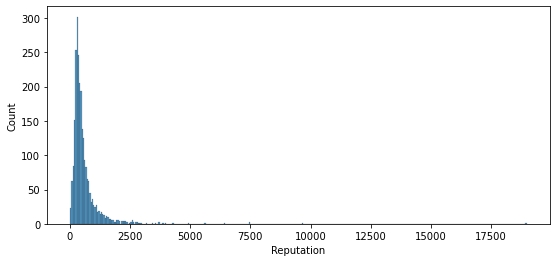

In [306]:
plt.figure(figsize=(9,4))
sns.histplot(x='badge_total', data=user_info)
plt.xlabel('Reputation')
plt.show();

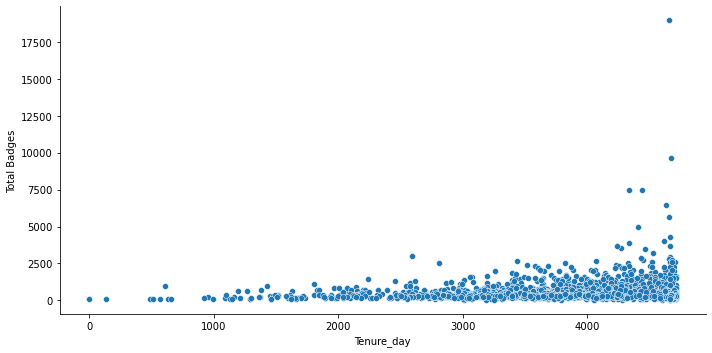

In [307]:
# total badges vs. tenure_year
sns.relplot(x='tenure_day', y='badge_total',data=user_info, kind='scatter',height=5,
    aspect=2)
plt.xlabel('Tenure_day')
plt.ylabel('Total Badges')
plt.show();

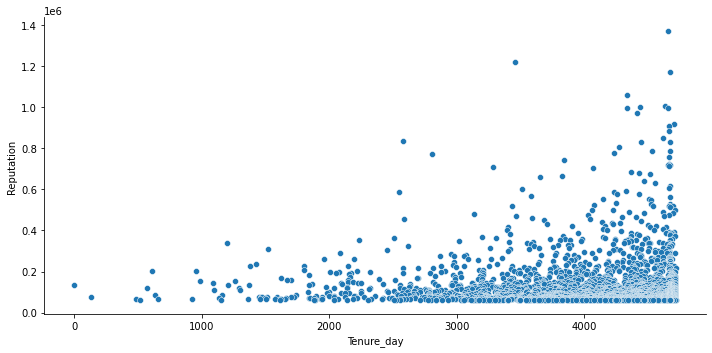

In [308]:
# reputation vs. tenure_year
sns.relplot(x='tenure_day', y='reputation',data=user_info, kind='scatter',height=5,
    aspect=2)
plt.xlabel('Tenure_day')
plt.ylabel('Reputation')
plt.show();

- there is no clear correlation between reputation and tenure.
- there is no clear correlation between total badges and tenure.

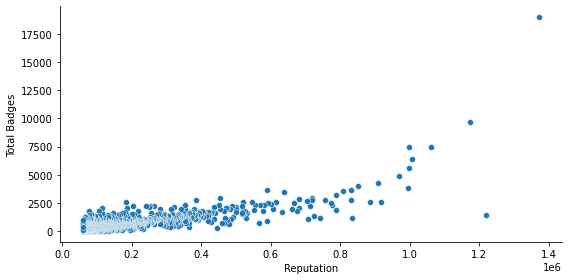

In [309]:
# total badges vs. reputation
sns.relplot(x='reputation', y='badge_total',data=user_info, kind='scatter',height=4,
    aspect=2)
plt.xlabel('Reputation')
plt.ylabel('Total Badges')
plt.show();

- A strong correlation exist between the total badges and reputation.

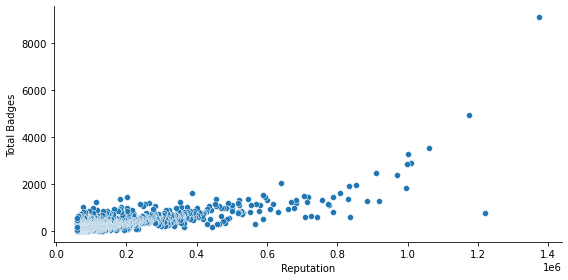

In [316]:
# total badges vs. reputation
sns.relplot(x='reputation', y='bronze',data=user_info, kind='scatter',height=4,
    aspect=2)
plt.xlabel('Reputation')
plt.ylabel('Total Badges')
plt.show();